# EEGMMIDB — Data Exploration & NeuroGPT Classification

Goal:
- Load the EEGMMIDB motor movement / imagery dataset
- Explore signals and labels
- Classification with NeuroGPT usage

In [1]:
!pip install mne "transformers[torch]" "accelerate>=0.26.0" tf-keras

  Using cached mne-1.11.0-py3-none-any.whl.metadata (15 kB)
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached tf_keras-2.20.1-py3-none-any.whl.metadata (1.8 kB)
Using cached mne-1.11.0-py3-none-any.whl (7.5 MB)
Using cached accelerate-1.12.0-py3-none-any.whl (380 kB)
Using cached tf_keras-2.20.1-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [tf-keras]2/3 [tf-keras]e]


## PhysioNet Dataset

In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch

# Project paths
PROJECT_ROOT = Path.cwd()
SRC_PATH = PROJECT_ROOT / "src"
DATA_PATH = PROJECT_ROOT / "data" / "physionet.org" / "files" / "eegmmidb" / "1.0.0"

sys.path.append(str(SRC_PATH))

from src.labram_dataloader import EEGMMIDBDataset

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA_PATH)

ModuleNotFoundError: No module named 'src.labram_dataloader'

In [ ]:
import mne

edf = DATA_PATH / "S001" / "S001R03.edf"
raw = mne.io.read_raw_edf(edf, preload=False, verbose=False)

print(raw.ch_names)


### Load Dataset for exploration

Subject 1, motor execution + imagery, left/right hand

Classes:
- 0: Right imagined
- 1: Right real
- 2: Left imagined
- 3: Left real

In [ ]:
dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=[1],
    runs=[4, 8, 12],
    t_min=0.0,
    t_max=4.0,
    normalization=True
)

print("Total extracted trials:", len(dataset))

In [ ]:
from collections import Counter

labels = [dataset[i]["labels"].item() for i in range(len(dataset))]

label_map = {
    0: "Left Imagined",
    1: "Right Imagined",
}

counts = Counter(labels)

print("Dataset-level class counts:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {counts.get(k, 0)}")


In [ ]:
print(labels)

In [ ]:
import mne
from collections import defaultdict

event_summary = defaultdict(lambda: defaultdict(int))

for run in [4, 8, 12]:
    edf_path = DATA_PATH / "S001" / f"S001R{run:02d}.edf"
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    
    _, event_id = mne.events_from_annotations(raw, verbose=False)
    
    for label in event_id.keys():
        event_code = label.split("/")[-1]
        event_summary[run][event_code] += 1

print("Raw EDF annotation summary (Subject 1):\n")
for run, events in event_summary.items():
    print(f"Run {run}: {dict(events)}")


In [ ]:
print("Sample-wise label sanity check (first 10 trials):\n")

for i in range(10):
    sample = dataset[i]
    label = sample["labels"].item()
    print(f"Trial {i:02d} -> Class {label}: {label_map[label]}")


In [ ]:
import numpy as np

energy_by_class = defaultdict(list)

for i in range(len(dataset)):
    sample = dataset[i]
    label = sample["labels"].item()
    energy = sample["inputs"].pow(2).mean().item()
    energy_by_class[label].append(energy)

print("Mean signal energy per class:")
for k in sorted(label_map):
    print(f"{label_map[k]:<15}: {np.mean(energy_by_class[k]):.4f}")


### NeuroGPT Teaser

Each trial is already:
- 22-channel (NeuroGPT format)
- Normalized
- Fixed-length
- Labeled

In [ ]:
batch = dataset[0]
print(batch["inputs"].shape)
print(batch["labels"].item())


### Loading the train, test data

In [ ]:
all_subjects = list(range(1, 109))  # subject range
print("Subjects:", all_subjects)

MI_ME_RUNS = [4, 8, 12]
print("MI_ME runs:", MI_ME_RUNS)

In [ ]:
# create folds

train_folds = []
test_folds = []

for i in range(len(all_subjects) // 2):
    test_subjects = all_subjects[i*2 : i*2+2]
    train_subjects = all_subjects[:i*2] + all_subjects[i*2+2:]

    train_folds.append(train_subjects)
    test_folds.append(test_subjects)


In [13]:
from src.labram_dataloader import EEGMMIDBDataset

"""
train_dataset = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=train_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=4.0,
    normalization=True
)
"""

test_dataset_EEG = EEGMMIDBDataset(
    root_path=str(DATA_PATH),
    subjects=test_subjects,
    runs=MI_ME_RUNS,
    t_min=0.0,
    t_max=4.0,
    normalization=True
)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [14]:
#print("Train trials:", len(train_dataset))
print("Test trials :", len(test_dataset_EEG))

batch = test_dataset_EEG[0]
print("Input shape:", batch["inputs"].shape)   # (22, T)
print("Label:", batch["labels"].item())


Test trials : 90
Input shape: torch.Size([64, 1600])
Label: 1


## BCI Datatset

In [32]:
import os
import sys
import json
home = os.environ["HOME"]
python_imports = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder"
cache_root = f"{home}/shared/DLN-2025W/notebook-eeg/Lab_GPT_based_EEG_decoder/"
sys.path.append(python_imports)

with open(os.path.join("NeuroGPT_mini/config.json"), "r", encoding="utf-8") as f:
    config = json.load(f)

In [33]:
import numpy as np
import torch
import os
import sys 
sys.path.insert(0,os.path.join('NeuroGPT_mini/') )
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, f1_score
import random
import json

### Import related to Transformer model (from files located in /NeuroGPT directory)

from encoder.conformer_braindecode import EEGConformer
from decoder.make_decoder import make_decoder
from embedder.make import make_embedder
from trainer.make import make_trainer
from trainer.base import Trainer
from decoder.unembedder import make_unembedder
import pandas as pd
from typing import Dict

import matplotlib.pyplot as plt

In [34]:
from BCIdataloader.labram_MIdataset import MotorImageryDataset

In [35]:
config_path = {"dst_data_path" : os.path.join(python_imports, "bciiv2a_eeg_npz/"),
         "pretrained_model" : os.path.join("NeuroGPT_mini/pytorch_model.bin"), 
         "log_dir" :os.path.join(python_imports,"training_logs/")}


In [36]:
# Compute the dataset (train, test, validation) 
downstream_path = config_path["dst_data_path"]
filenames = sorted(os.listdir(downstream_path))[:18]
print("Files from all the subjects : ", filenames)
train_folds = []
test_folds = []

for i in range(9):
    train_files = filenames[0:i*2] + filenames[i*2+2:]
    test_files = filenames[i*2 : i*2+2]


print("Train dataset : ")
print(train_files)


train_dataset = MotorImageryDataset(train_files, root_path=downstream_path)


print("Test dataset :")
print(test_files)

# On the way, compute the test dataset as :

## TO DO : instanciate a MotorImageryDataset object but with the testing files
# test_dataset = ... 
# YOUR CODE HERE
validation_dataset = MotorImageryDataset(test_files, root_path=downstream_path)

batch = train_dataset[0]
print("Input shape:", batch["inputs"].shape)   # (22, T)
print("Label:", batch["labels"].item())


Files from all the subjects :  ['A01E.npz', 'A01T.npz', 'A02E.npz', 'A02T.npz', 'A03E.npz', 'A03T.npz', 'A04E.npz', 'A04T.npz', 'A05E.npz', 'A05T.npz', 'A06E.npz', 'A06T.npz', 'A07E.npz', 'A07T.npz', 'A08E.npz', 'A08T.npz', 'A09E.npz', 'A09T.npz']
Train dataset : 
['A01E.npz', 'A01T.npz', 'A02E.npz', 'A02T.npz', 'A03E.npz', 'A03T.npz', 'A04E.npz', 'A04T.npz', 'A05E.npz', 'A05T.npz', 'A06E.npz', 'A06T.npz', 'A07E.npz', 'A07T.npz', 'A08E.npz', 'A08T.npz']
Test dataset :
['A09E.npz', 'A09T.npz']
Input shape: torch.Size([64, 1600])
Label: 1


## Compare and align datasets

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compare_datasets(bci_ds, eegmmi_ds):
    # 1. Pull one sample
    bci_sample = bci_ds[0]
    eeg_sample = eegmmi_ds[0]
    
    # 2. Extract data
    bci_data = bci_sample["inputs"]
    eeg_data = eeg_sample["inputs"]
    
    print("=== Dataset Alignment Report ===")
    
    # Check Shapes
    print(f"\n[Shape Check]")
    print(f"BCI Shape:    {list(bci_data.shape)}")
    print(f"EEGMMI Shape: {list(eeg_data.shape)}")
    if bci_data.shape == eeg_data.shape:
        print("✅ Shapes match.")
    else:
        print("❌ SHAPE MISMATCH! The model will crash.")

    # Check Statistics (Scaling)
    print(f"\n[Statistics Check]")
    print(f"BCI Mean: {bci_data.mean().item():.4f} | Std: {bci_data.std().item():.4f}")
    print(f"EEG Mean: {eeg_data.mean().item():.4f} | Std: {eeg_data.std().item():.4f}")
    
    # Check Channels (Projection)
    print(f"\n[Channel/Projection Check]")
    print(f"BCI Number of Channels: {bci_data.shape[-2]}")
    print(f"EEG Number of Channels: {eeg_data.shape[-2]}")
# Run the comparison
# (Assuming you've initialized 'train_dataset' and 'test_dataset')
compare_datasets(train_dataset, validation_dataset)

=== Dataset Alignment Report ===

[Shape Check]
BCI Shape:    [64, 1600]
EEGMMI Shape: [64, 1600]
✅ Shapes match.

[Statistics Check]
BCI Mean: -0.0000 | Std: 0.4635
EEG Mean: 0.0000 | Std: 0.4635

[Channel/Projection Check]
BCI Number of Channels: 64
EEG Number of Channels: 64


In [37]:
from collections import Counter

# Check Training Labels
train_counts = Counter(train_dataset.labels)
print(f"Training Label Distribution: {train_counts}")
# Expected: {0: count_left, 1: count_right}

# Check Test Labels
test_counts = Counter(validation_dataset.labels)
print(f"Test Label Distribution: {test_counts}")

Training Label Distribution: Counter({1: 576, 0: 576})
Test Label Distribution: Counter({1: 72, 0: 72})


## Model

In [22]:
!pip install braindecode

In [46]:
from braindecode.models import Labram
import torch.nn as nn
import torch

# 1. Initialize with the specs that matched (64 channels, 1600 samples)
model = Labram(
    n_chans=64, 
    n_times=1600, 
    n_outputs=2
)

# 2. Load the state dict
url = "https://huggingface.co/braindecode/Labram-Braindecode/resolve/main/braindecode_labram_base.pt"
state = torch.hub.load_state_dict_from_url(url, map_location='cpu')

if 'model' in state:
    state = state['model']

# 3. MANUALLY REMOVE the mismatched head layers
# This is the crucial step to prevent the RuntimeError
keys_to_remove = ["final_layer.weight", "final_layer.bias"]
for key in keys_to_remove:
    if key in state:
        del state[key]
        print(f"Removed {key} from state_dict to allow 2-class head.")

# 4. Now load with strict=False
# This will load the encoder and leave your new final_layer randomized
model.load_state_dict(state, strict=False)
print("SUCCESS: Encoder weights loaded. Final layer remains initialized for 2 classes.")

import torch.nn as nn
from argparse import Namespace

class LabramTrainerWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.model = base_model
        # Create a mock config to satisfy the Trainer's internal checks
        self.config = Namespace(problem_type="single_label_classification") 
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, inputs, labels=None):
        # inputs: (Batch, 64, 1600)
        logits = self.model(inputs)
        
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            
        return {"loss": loss, "logits": logits}

model_for_trainer = LabramTrainerWrapper(model)

Removed final_layer.weight from state_dict to allow 2-class head.
Removed final_layer.bias from state_dict to allow 2-class head.
SUCCESS: Encoder weights loaded. Final layer remains initialized for 2 classes.


In [47]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = balanced_accuracy_score(labels, predictions)
    kappa = cohen_kappa_score(labels, predictions)
    
    return {
        "balanced_accuracy": acc,
        "kappa": kappa
    }

In [48]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./labram_finetuning",
    learning_rate=5e-6,           # Low learning rate for foundation models
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,          # Allow enough epochs for the head to adapt
    weight_decay=0.1,
    logging_steps=10,
    eval_strategy="epoch",  # Monitor cross-dataset performance every epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="balanced_accuracy",
    remove_unused_columns=False,  # DO NOT change this
    report_to="none" ,             # Change to "wandb" if you use it
    label_smoothing_factor=0.1
)

In [49]:
print(f"Total BCI Training Trials: {len(train_dataset)}")
print(f"Total PhysioNet Test Trials: {len(validation_dataset)}")

# Check a single sample shape
sample = train_dataset[0]
print(f"Input shape: {sample['inputs'].shape}") # Should be [64, 1600]
print(f"Label: {sample['labels']}")

Total BCI Training Trials: 1152
Total PhysioNet Test Trials: 144
Input shape: torch.Size([64, 1600])
Label: 1


In [50]:
# Initialize Trainer
trainer = Trainer(
    model=model_for_trainer,
    args=training_args,
    train_dataset=train_dataset,      # BCI IV 2a
    eval_dataset=validation_dataset,    # PhysioNet
    compute_metrics=compute_metrics,
)

# 1. Start Training (Fine-tuning)
trainer.train()

# 2. Final Evaluation
print("\n--- Final Cross-Dataset Results ---")
final_results = trainer.evaluate()
print(final_results)

Epoch,Training Loss,Validation Loss,Balanced Accuracy,Kappa
1,0.693700,0.693228,0.520833,0.041667
2,0.691400,0.692991,0.500000,0.000000
3,0.685100,0.693067,0.500000,0.000000
4,0.675700,0.696384,0.479167,-0.041667
5,0.652300,0.696075,0.513889,0.027778
6,0.637000,0.699555,0.493056,-0.013889
7,0.605900,0.702777,0.493056,-0.013889
8,0.588900,0.714710,0.493056,-0.013889
9,0.574800,0.725582,0.472222,-0.055556
10,0.525700,0.741276,0.458333,-0.083333


KeyboardInterrupt: 

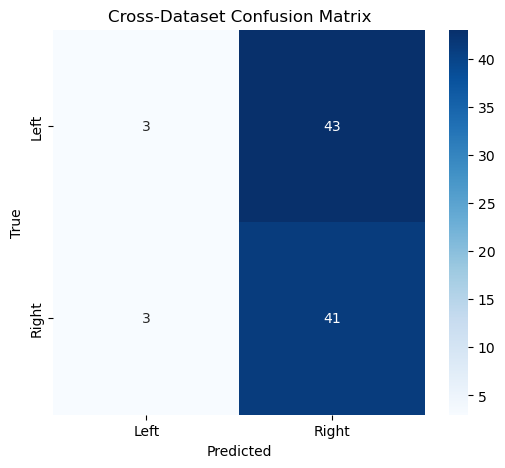

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    balanced_accuracy_score, 
    cohen_kappa_score, 
    f1_score, 
    confusion_matrix
)

# Get predictions on PhysioNet
predictions = trainer.predict(test_dataset_EEG)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# Plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Cross-Dataset Confusion Matrix')
plt.show()